In [10]:
import time

import numpy as np

from mc_lab.inverse_transform import (
    StratifiedInverseTransformSampler,
    create_sampler,
)

In [11]:
# Demonstration and examples
def demo_unified_framework():
    """Demonstrate the unified framework with different samplers."""

    print("Unified Inverse Transform Sampling Framework Demo")
    print("=" * 60)

    # Example 1: Analytical inverse CDF (Exponential distribution)
    print("\n1. Analytical Method - Exponential Distribution")
    print("-" * 50)

    def exp_inverse_cdf(u, rate=2.0):
        return -np.log(1 - u) / rate

    # Create analytical sampler
    exp_sampler = create_sampler(
        inverse_cdf=lambda u: exp_inverse_cdf(u, rate=2.0),
        method="analytical",
        random_state=42,
    )

    samples = exp_sampler.sample(100000)
    print(f"Sample mean: {np.mean(samples):.4f} (expected: {0.5:.4f})")
    print(f"Sample std:  {np.std(samples):.4f} (expected: {0.5:.4f})")

    # Example 2: Numerical inverse CDF (Beta distribution)
    print("\n2. Numerical Method - Beta Distribution")
    print("-" * 50)

    from scipy.stats import beta

    alpha, beta_param = 2, 5

    def beta_cdf(x):
        return beta.cdf(x, alpha, beta_param)

    # Create numerical sampler
    beta_sampler = create_sampler(
        cdf=beta_cdf, x_range=(0, 1), method="numerical", n_points=1000, random_state=42
    )

    samples = beta_sampler.sample(10000)
    expected_mean = alpha / (alpha + beta_param)
    print(f"Sample mean: {np.mean(samples):.4f} (expected: {expected_mean:.4f})")

    # Example 3: Enhanced samplers using the same base
    print("\n3. Enhanced Sampling Methods")
    print("-" * 50)

    # Stratified sampling
    stratified_sampler = StratifiedInverseTransformSampler(
        base_sampler=beta_sampler, n_strata=20, random_state=42
    )

    stratified_samples = stratified_sampler.sample(10000)
    print(f"Stratified mean: {np.mean(stratified_samples):.4f}")
    print(f"Variance reduction: {np.var(samples) / np.var(stratified_samples):.2f}x")

    # Example 4: Quantile sampling
    print("\n4. Quantile Sampling")
    print("-" * 50)

    quantiles = np.array([0.1, 0.25, 0.5, 0.75, 0.9])
    quantile_values = beta_sampler.sample_quantiles(quantiles)

    print("Beta(2,5) Quantiles:")
    for q, val in zip(quantiles, np.asarray(quantile_values)):
        print(f"  Q({q:.2f}) = {val:.4f}")

    # Performance comparison
    print("\n5. Performance Comparison")
    print("-" * 50)

    n_samples = 50000

    methods = [
        ("Analytical", exp_sampler),
        ("Numerical", beta_sampler),
        ("Stratified", stratified_sampler),
    ]

    for name, sampler in methods:
        start_time = time.time()
        _ = sampler.sample(n_samples, random_state=42)
        elapsed = time.time() - start_time
        print(f"{name:<12}: {elapsed:.4f}s ({n_samples / elapsed:,.0f} samples/s)")


if __name__ == "__main__":
    demo_unified_framework()

Unified Inverse Transform Sampling Framework Demo

1. Analytical Method - Exponential Distribution
--------------------------------------------------
Sample mean: 0.4980 (expected: 0.5000)
Sample std:  0.4965 (expected: 0.5000)

2. Numerical Method - Beta Distribution
--------------------------------------------------
Sample mean: 0.2823 (expected: 0.2857)

3. Enhanced Sampling Methods
--------------------------------------------------
Stratified mean: 0.2854
Variance reduction: 0.99x

4. Quantile Sampling
--------------------------------------------------
Beta(2,5) Quantiles:
  Q(0.10) = 0.0926
  Q(0.25) = 0.1612
  Q(0.50) = 0.2645
  Q(0.75) = 0.3895
  Q(0.90) = 0.5103

5. Performance Comparison
--------------------------------------------------
Analytical  : 0.0009s (57,393,322 samples/s)
Numerical   : 0.0042s (11,990,577 samples/s)
Stratified  : 0.0041s (12,209,070 samples/s)


In [12]:
# Example 6: Discrete Distributions
print("\n6. Discrete Distribution - Poisson-like Example")
print("-" * 50)

# Define a custom discrete distribution (truncated geometric)
# P(X = k) = (1-p)^(k-1) * p for k = 1, 2, ..., max_k
p = 0.3
max_k = 20
values = np.arange(1, max_k + 1)

# Probability mass function
pmf = [(1 - p) ** (k - 1) * p for k in values]
pmf = np.array(pmf)
pmf = pmf / pmf.sum()  # Normalize due to truncation

# Cumulative distribution function
cdf_vals = np.cumsum(pmf)


def discrete_cdf(x):
    """CDF for truncated geometric distribution."""
    x = np.asarray(x)
    result = np.zeros_like(x, dtype=float)

    for i, xi in enumerate(x.flat):
        if xi < 1:
            result.flat[i] = 0.0
        elif xi >= max_k:
            result.flat[i] = 1.0
        else:
            # Find the largest integer value <= xi
            k_index = int(np.floor(xi)) - 1
            if k_index >= 0 and k_index < len(cdf_vals):
                result.flat[i] = cdf_vals[k_index]
            else:
                result.flat[i] = 1.0

    return result


def discrete_inverse_cdf(u):
    """Analytical inverse CDF using searchsorted."""
    u = np.asarray(u)
    # Use searchsorted to find where u falls in the CDF
    indices = np.searchsorted(cdf_vals, u, side="right")
    return values[np.clip(indices, 0, len(values) - 1)]


# Method 1: Analytical discrete inverse
discrete_analytical = create_sampler(
    inverse_cdf=discrete_inverse_cdf, method="analytical", random_state=42
)

samples_analytical = discrete_analytical.sample(10000)
print("Analytical method:")
print(f"  Sample mean: {np.mean(samples_analytical):.4f}")
print(f"  Sample std:  {np.std(samples_analytical):.4f}")

# Method 2: Numerical method
discrete_numerical = create_sampler(
    cdf=discrete_cdf,
    x_range=(0.5, max_k + 0.5),
    method="numerical",
    n_points=max_k * 10,
    random_state=42,
)

samples_numerical = discrete_numerical.sample(10000)
print("Numerical method:")
print(f"  Sample mean: {np.mean(samples_numerical):.4f}")
print(f"  Sample std:  {np.std(samples_numerical):.4f}")

# Verify distribution
print("\nEmpirical vs Theoretical PMF (first 10 values):")
unique_vals, counts = np.unique(samples_analytical, return_counts=True)
empirical_pmf = counts / len(samples_analytical)

print("Value  Empirical  Theoretical")
for i in range(min(10, len(unique_vals))):
    k = int(unique_vals[i])
    if k <= len(pmf):
        theoretical = pmf[k - 1] if k >= 1 else 0
        empirical = empirical_pmf[i]
        print(f"{k:5d}  {empirical:9.4f}  {theoretical:11.4f}")

# Performance comparison for discrete
print("\nDiscrete sampling performance:")
print(f"  Analytical: {len(samples_analytical)} samples")
print(f"  Numerical:  {len(samples_numerical)} samples")


6. Discrete Distribution - Poisson-like Example
--------------------------------------------------
Analytical method:
  Sample mean: 3.2574
  Sample std:  2.6720
Numerical method:
  Sample mean: 3.2209
  Sample std:  2.6856

Empirical vs Theoretical PMF (first 10 values):
Value  Empirical  Theoretical
    1     0.3054       0.3002
    2     0.2142       0.2102
    3     0.1473       0.1471
    4     0.1011       0.1030
    5     0.0716       0.0721
    6     0.0486       0.0505
    7     0.0321       0.0353
    8     0.0242       0.0247
    9     0.0182       0.0173
   10     0.0129       0.0121

Discrete sampling performance:
  Analytical: 10000 samples
  Numerical:  10000 samples


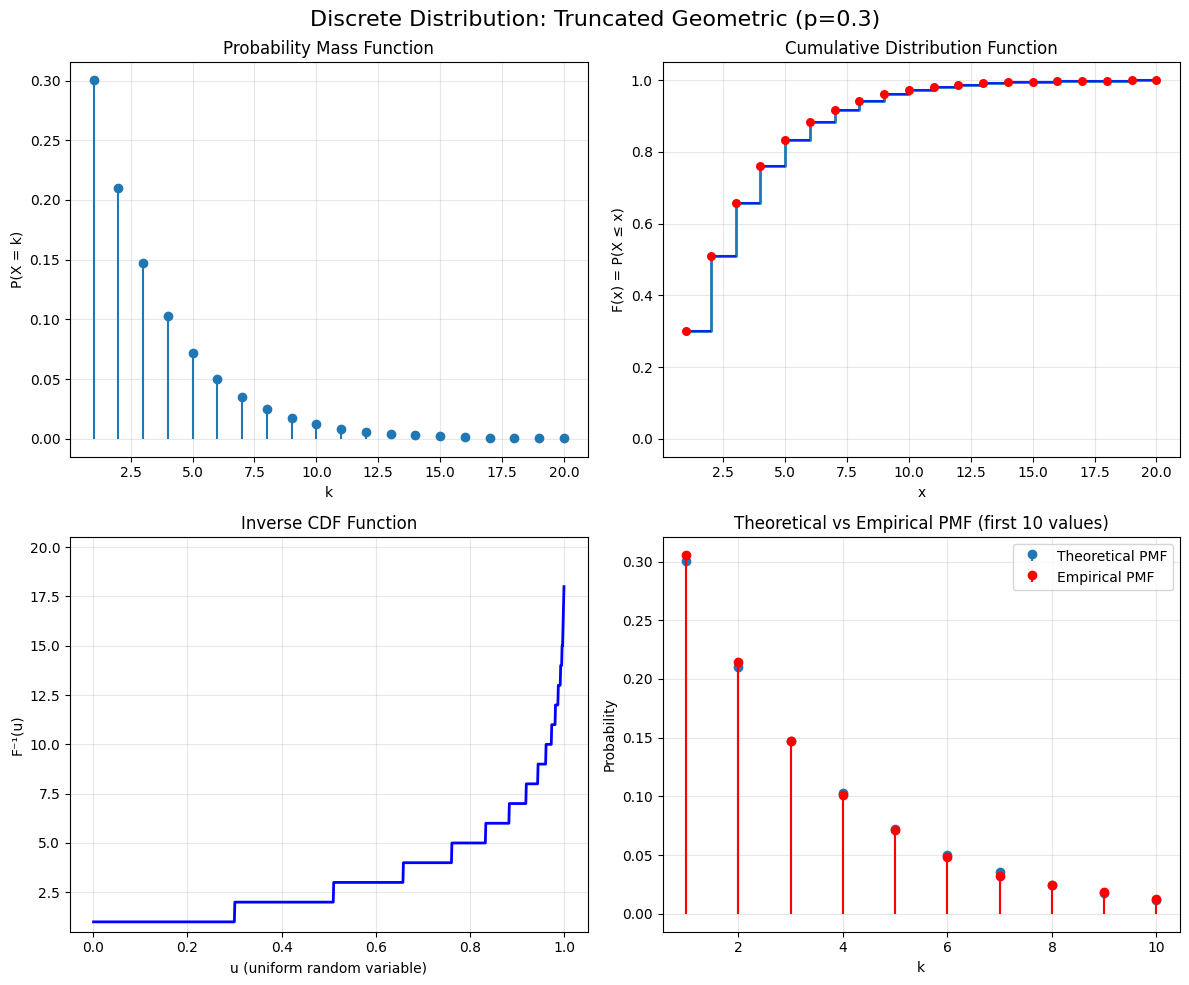


Inverse Transform Process Demonstration:
u (uniform) → F⁻¹(u) (discrete value)
u = 0.1 → X = 1
u = 0.3 → X = 1
u = 0.5 → X = 2
u = 0.7 → X = 4
u = 0.9 → X = 7


In [15]:
# Visualizations for discrete distribution
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Discrete Distribution: Truncated Geometric (p=0.3)", fontsize=16)

# 1. PMF visualization
ax1.stem(values, pmf, basefmt=" ")
ax1.set_xlabel("k")
ax1.set_ylabel("P(X = k)")
ax1.set_title("Probability Mass Function")
ax1.grid(True, alpha=0.3)

# 2. CDF visualization
ax2.step(values, cdf_vals, where="post", linewidth=2, label="Theoretical CDF")
ax2.scatter(values, cdf_vals, color="red", s=30, zorder=5)
# Add horizontal lines to show step function nature
for i in range(len(values) - 1):
    ax2.hlines(cdf_vals[i], values[i], values[i + 1], colors="blue", alpha=0.7)
ax2.set_xlabel("x")
ax2.set_ylabel("F(x) = P(X ≤ x)")
ax2.set_title("Cumulative Distribution Function")
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-0.05, 1.05)

# 3. Inverse CDF visualization
u_range = np.linspace(0.001, 0.999, 1000)
inverse_values = discrete_inverse_cdf(u_range)
ax3.plot(u_range, inverse_values, "b-", linewidth=2, label="Inverse CDF")
ax3.set_xlabel("u (uniform random variable)")
ax3.set_ylabel("F⁻¹(u)")
ax3.set_title("Inverse CDF Function")
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0.5, max_k + 0.5)

# 4. Sample histogram vs theoretical PMF
sample_values, sample_counts = np.unique(samples_analytical, return_counts=True)
sample_pmf = sample_counts / len(samples_analytical)

ax4.stem(values[:10], pmf[:10], basefmt=" ", label="Theoretical PMF")
ax4.stem(
    sample_values[:10],
    sample_pmf[:10],
    basefmt=" ",
    label="Empirical PMF",
    linefmt="r-",
    markerfmt="ro",
)
ax4.set_xlabel("k")
ax4.set_ylabel("Probability")
ax4.set_title("Theoretical vs Empirical PMF (first 10 values)")
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Demonstrate the inverse transform process
print("\nInverse Transform Process Demonstration:")
print("=" * 50)
print("u (uniform) → F⁻¹(u) (discrete value)")
test_u_values = [0.1, 0.3, 0.5, 0.7, 0.9]
for u in test_u_values:
    discrete_val = discrete_inverse_cdf([u])[0]
    print(f"u = {u:.1f} → X = {discrete_val}")